# Swissroads Project: 06 - Non linear classifiers  

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.


## Aim of this notebook  

The goal of this jupyter notebook, is to classify images of vehicles which are part of the swissroads dataset, using non linear classifiers, such as random forests and svms. 

The dataset was first preprocessed with the Inception_v3 convolutional network of the tensorflow hub, in order to extract 2048 high-level features. 

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# loading data
# Load data
with np.load('data/train.npz', allow_pickle=False) as npz_file:
    X_tr = npz_file['features']
    y_tr = npz_file['targets']
    names_tr = npz_file['names']
    
with np.load('data/valid.npz', allow_pickle=False) as npz_file:
    X_val = npz_file['features']
    y_val = npz_file['targets']
    names_val = npz_file['names']
    
with np.load('data/test.npz', allow_pickle=False) as npz_file:
    X_te = npz_file['features']
    y_te = npz_file['targets']
    names_te = npz_file['names']

In [3]:
# numerical encoding of target variables

encoder = OrdinalEncoder()
enc_y_tr = encoder.fit_transform(y_tr.reshape(-1, 1))
enc_y_val = encoder.transform(y_val.reshape(-1, 1))
enc_y_te = encoder.transform(y_te.reshape(-1, 1))


## Random forest

For the first part of this notebook, we will train a random forest, first on the 2048 high level features, then after reducing dimensions with a PCA. 

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV

First, let's try a random forest without tuning: 

In [5]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy =  metrics.accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy*100))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_tr, np.ravel(enc_y_tr))
base_accuracy = evaluate(base_model, X_val, np.ravel(enc_y_val))

Model Performance
Accuracy = 85.61%.


The validation accuracy on an untrained model is already of 86%.

Let's now fine tune our classifier. 
We will tune the following parameters: 

* n_estimators: the number of trees in the random forest
* max_features: the number of features to consider when looking for the best split
* max_depth: The maximum number of levels in the trees
* min_samples_split: the minimum number of samples required to split a node
* min_samples_leaf: the minimum number of samples required at each leaf node
* bootstrap: the method of selecting samples for training each tree

In [6]:
# create parameter grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
params_dict = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [7]:
#create  pipeline
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params_dict, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [8]:
# Fit the random search model
rf_random.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [9]:
rf_random.best_params_


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [10]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_te, enc_y_te)

Model Performance
Accuracy = 94.00%.


The resulting performance is the same as the tuned decision tree with dimension reduction 



As an experiment, we play with the number of tree in the forest ( numbe of estimators0, while keeping the other optimal parameters fixed). 

In [11]:
rf_test_nestimators = RandomForestClassifier(min_samples_split = rf_random.best_params_['min_samples_split'], 
                                             min_samples_leaf = rf_random.best_params_['min_samples_leaf'], 
                                             max_features = rf_random.best_params_['max_features'],
                                             max_depth = rf_random.best_params_['max_depth'],
                                             bootstrap = rf_random.best_params_['bootstrap']
                                            )
params_dict_esti = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 2000, num = 200)]}
rf_random_nestimators = RandomizedSearchCV(estimator = rf_test_nestimators,n_iter = 200,  param_distributions = params_dict_esti, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random_nestimators.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    max_depth=40,
                                                    max_features='sqrt'),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'n_estimators': [1, 11, 21, 31, 41, 51,
                                                         61, 71, 81, 91, 101,
                                                         111, 121, 131, 141,
                                                         151, 161, 171, 181,
                                                         191, 201, 211, 221,
                                                         232, 242, 252, 262,
                                                         272, 282, 292, ...]},
                   random_state=42, verbose=2)

In [12]:
df_estimators = pd.DataFrame(rf_random_nestimators.cv_results_['params'], rf_random_nestimators.cv_results_['mean_test_score']).reset_index()
df_estimators = df_estimators.sort_values(by = 'n_estimators', ascending = True)

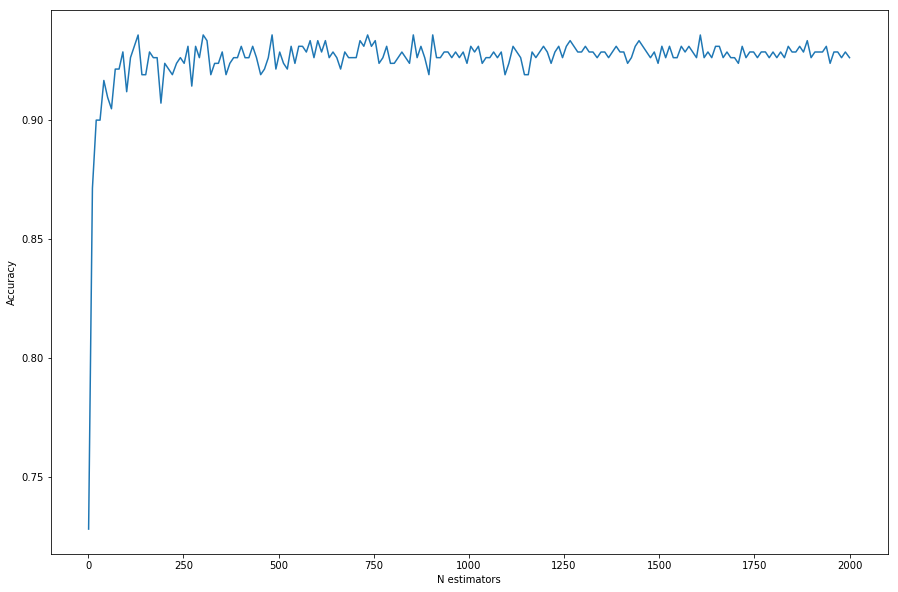

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
plt.plot(df_estimators['n_estimators'] , df_estimators['index'])
plt.xlabel('N estimators')
plt.ylabel('Accuracy')
plt.show()

We can see that increasing the number of estimators in the forest increases the accuracy, but only until a certain point after which, we reach a plateau and the accuracy doesnt increase anymore. 

## SVM 

Next, we try to fit a linear SVM. 

For this classifier, we will tune the following parameters: 
* penalty: specifies the norm used in the SVC, with l1 being a sparse solution and the l2 being the regular norm
* loss function: the loss function to use
* regularization strength: The bigger the C parameter, the weaker the regularization.

In [15]:
from sklearn.svm import LinearSVC

# Create SVM with linear kernel
linear_svc = LinearSVC(random_state = 0, max_iter = 10000, dual = True)


In [16]:
# create parameter grid
# penalty
penalty = ['l1', 'l2']
# regularization strength 
C = [0.001, 0.01, 0.1,1, 10, 100, 1000]


# Create the random grid
params_dict = [{'penalty': penalty,
               'loss': ['hinge'],
               'C': C
              }, 
               {'penalty': ["l2"],
               'loss': ['squared_hinge'],
               'C': C
              }
              ]

In [17]:
from sklearn.model_selection import GridSearchCV
grid_search_linear = GridSearchCV(estimator = linear_svc, param_grid = params_dict, 
                          cv = 10, n_jobs = -1, verbose = 2, error_score = np.nan)

In [18]:
grid_search_linear.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))
grid_search_linear.best_params_

Fitting 10 folds for each of 21 candidates, totalling 210 fits


C:\Users\Valou\anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.87828107        nan 0.92839721        nan 0.91643438
        nan 0.91643438        nan 0.91643438        nan 0.91643438
        nan 0.91643438 0.92119628 0.92351916 0.91881533 0.91643438
 0.91643438 0.91643438 0.91643438]
  category=UserWarning


{'C': 0.01, 'loss': 'hinge', 'penalty': 'l2'}

The best performance is achieved with C = 0.01, a hinged loss function and the regular l2 norm. 

In [19]:
best_grid_linear = grid_search_linear.best_estimator_
grid_accuracy_linear = evaluate(best_grid_linear, X_te, enc_y_te)

Model Performance
Accuracy = 96.00%.


The test accuracy on this tuned linear SVM is 96%, which is slightly better than for the random forest> 

Now, let's tune SVM with a RBF kernel. 

### RBF kernel 

For this classifier, we will tune: 
* C: the regularization parameter
* Gamma: the kernel coefficient

In [20]:
from sklearn.svm import SVC
rbf_svc = SVC(random_state= 0)

In [21]:
# create parameter grid
# regularization strength 
C = [0.001, 0.01, 0.1,1, 10, 100, 1000]

gamma = [0.001, 0.01, 0.1,1, 10, 100, 1000]

# Create the random grid
params_dict = {'gamma' : gamma,
               'C': C,              
              }

In [22]:
grid_search_rbf = GridSearchCV(estimator = rbf_svc, param_grid = params_dict, 
                          cv = 10, n_jobs = -1, verbose = 2, error_score = np.nan)

In [23]:
grid_search_rbf.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))
grid_search_rbf.best_params_

Fitting 10 folds for each of 49 candidates, totalling 490 fits


{'C': 100, 'gamma': 0.001}

The best accuracy is achieved with C = 100, which is rather large and means that there is no regularization, and gamma = 0.001. 

In [24]:
best_grid_rbf = grid_search_rbf.best_estimator_
grid_accuracy_rbf = evaluate(best_grid_rbf, X_te, enc_y_te)

Model Performance
Accuracy = 96.00%.


We have the same performance using a tuned linear SVM vs a tuned RBF kernel SVM, and both perform slightly better than the random forest. 

Finally, we save these results in order to compare all different models. 

In [25]:
np.savez('results/05_random_forest.npz', test_accuracy=random_accuracy)
np.savez('results/06_linear_svm.npz', test_accuracy=grid_accuracy_linear)
np.savez('results/07_rbf_svm.npz', test_accuracy=grid_accuracy_rbf)
